# 7.3 Using built-in training and evaluation loops

### *The standard workflow: `compile()`, `fit()`, `evaluate()`, `predict()`*

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation='relu')(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation='softmax')(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()

# Compile the model by specifying its optimizer, the loss function to minimize, and the metrics to monitor.
model.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]) 

# Use fit() to train the model, optionally providing validation data to monitor performance on unseen data.
model.fit(train_images, train_labels, epochs=3,
          validation_data=(val_images, val_labels))

# Use evaluate() to compute the loss and metrics on new data.
test_metrics = model.evaluate(test_images, test_labels)

# Use predict() to compute classification probabilities on new data.
predictions = model.predict(test_images) 

Epoch 1/3
1563/1563 [==============================] - 14s 8ms/step - loss: 0.2952 - accuracy: 0.9128 - val_loss: 0.1714 - val_accuracy: 0.9514
Epoch 2/3
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1608 - accuracy: 0.9533 - val_loss: 0.1260 - val_accuracy: 0.9640
Epoch 3/3
313/313 [==============================] - 1s 2ms/step


There are a couple of ways you can customize this simple workflow:
- Provide your own custom metrics.
- Pass callbacks to the `fit()` method to schedule actions to be taken at specific
points during training.

Let’s take a look at these.

## 7.3.1 Writing your own metrics

Metrics are key to measuring the performance of your model—in particular, to measuring the difference between its performance on the training data and its performance on the test data. Commonly used metrics for classification and regression are
already part of the built-in `keras.metrics` module, and most of the time that’s what
you will use. But if you’re doing anything out of the ordinary, you will need to be able
to write your own metrics. It’s simple!

 A Keras metric is a subclass of the `keras.metrics.Metric` class. Like layers, a metric has an internal state stored in TensorFlow variables. Unlike layers, these variables
aren’t updated via backpropagation, so you have to write the state-update logic yourself, which happens in the `update_state()` method.

 For example, here’s a simple custom metric that measures the root mean squared
error (RMSE).

### *Implementing a custom metric by subclassing the `Metric` class*

In [2]:
import tensorflow as tf

# Subclass the Metric class.
class RootMeanSquaredError(keras.metrics.Metric):
    
    # Define the state variables in the constructor. Like for layers, you have access to the add_weight() method.
    def __init__(self, name='rmse', **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name='mse_sum', initializer='zeros')
        self.total_samples = self.add_weight(name='total_samples', initializer='zeros', dtype='int32')
        
    # Implement the state update logic in update_state(). The y_true argument is the targets (or labels) for one batch, 
    # while y_pred represents the corresponding predictions from the model. You can ignore the sample_weight argument—
    # we won’t use it here.
    def update_state(self, y_true, y_pred, sample_weight=None):
        # To match our MNIST model, we expect categorical predictions and integer labels.
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)
        
    # Return the current value of the metric.
    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))
    
    # Expose a way to reset the metric state without having to reinstantiate it—
    # this enables the same metric objects to be used across different
    # epochs of training or across both training and evaluation.
    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

Custom metrics can be used just like built-in ones. You can now see the `fit()` progress bar displaying the RMSE of your model. 

In [3]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels, epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 15s 9ms/step - loss: 0.2937 - accuracy: 0.9127 - rmse: 7.1782 - val_loss: 0.1462 - val_accuracy: 0.9570 - val_rmse: 7.3566
Epoch 2/3
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1612 - accuracy: 0.9543 - rmse: 7.3517 - val_loss: 0.1288 - val_accuracy: 0.9638 - val_rmse: 7.3998
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.0928 - accuracy: 0.9758 - rmse: 7.4376


## 7.3.2 Using callbacks

A callback is an object (a class instance implementing specific methods) that is passed to the model in the call to `fit()` and that is called by the model at various points during training. It has access to all the available data about the state of the model and its performance, and it can take action: interrupt training, save a model, load a different weight set, or otherwise alter the state of the model.

 Here are some examples of ways you can use callbacks:
- *Model checkpointing*—Saving the current state of the model at different points during training.
- *Early stopping*—Interrupting training when the validation loss is no longer improving (and of course, saving the best model obtained during training).
- *Dynamically adjusting the value of certain parameters during training*—Such as the learning rate of the optimizer.
- *Logging training and validation metrics during training, or visualizing the representations learned by the model as they’re updated*—The `fit()` progress bar that you’re familiar with is in fact a callback!

The `keras.callbacks` module includes a number of built-in callbacks (this is not an
exhaustive list):
- `keras.callbacks.ModelCheckpoint`
- `keras.callbacks.EarlyStopping`
- `keras.callbacks.LearningRateScheduler`
- `keras.callbacks.ReduceLROnPlateau`
- `keras.callbacks.CSVLogger`

Let’s review two of them to give you an idea of how to use them: `EarlyStopping` and
`ModelCheckpoint`.

### The `EarlyStopping` and `ModelCheckpoint` callbacks

When you’re training a model, there are many things you can’t predict from the start.
In particular, you can’t tell how many epochs will be needed to get to an optimal validation loss. Our examples so far have adopted the strategy of training for enough
epochs that you begin overfitting, using the first run to figure out the proper number
of epochs to train for, and then finally launching a new training run from scratch
using this optimal number. Of course, this approach is wasteful. A much better way to
handle this is to stop training when you measure that the validation loss is no longer
improving. This can be achieved using the `EarlyStopping` callback.

 The `EarlyStopping` callback interrupts training once a target metric being monitored has stopped improving for a fixed number of epochs. For instance, this callback
allows you to interrupt training as soon as you start overfitting, thus avoiding having to
retrain your model for a smaller number of epochs. This callback is typically used in
combination with `ModelCheckpoint`, which lets you continually save the model during
training (and, optionally, save only the current best model so far: the version of the
model that achieved the best performance at the end of an epoch).

### *Using the `callbacks` argument in the `fit()` method*

In [4]:
# Callbacks are passed to the model via the callbacks argument in fit(), which takes a list of callbacks.
# You can pass any number of callbacks.
callbacks_list = [
    keras.callbacks.EarlyStopping( # Interrupts training when improvement stops.
        monitor="val_accuracy",    # Monitors the model's validation accuracy.
        patience=2,                # Interrupts training when accuracy has stopped improving for two epochs.
    ),
    keras.callbacks.ModelCheckpoint(      # Saves the current weights after every epoch.
        filepath="checkpoint_path.keras", # Path to the destination model file.
        monitor="val_loss",               # These two arguments mean you won’t overwrite the model file unless val_loss  
        save_best_only=True,              # has improved, which allows you to keep the best model seen during training.
    )
]

model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])       # You monitor accuracy, so it should be part of the model’s metrics.

# Note that because the callback will monitor validation loss and validation accuracy, 
# you need to pass validation_data to the call to fit().
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.2972 - accuracy: 0.9117 - val_loss: 0.1480 - val_accuracy: 0.9570
Epoch 2/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1611 - accuracy: 0.9531 - val_loss: 0.1206 - val_accuracy: 0.9676
Epoch 3/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1303 - accuracy: 0.9629 - val_loss: 0.1062 - val_accuracy: 0.9713
Epoch 4/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1151 - accuracy: 0.9688 - val_loss: 0.1020 - val_accuracy: 0.9738
Epoch 5/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1061 - accuracy: 0.9713 - val_loss: 0.0956 - val_accuracy: 0.9754
Epoch 6/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0955 - accuracy: 0.9746 - val_loss: 0.0861 - val_accuracy: 0.9792
Epoch 7/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0887 - accuracy: 0.9751 - val_loss: 0.0928 - val_ac

Note that you can always save models manually after training as well—just call
`model.save('my_checkpoint_path')`. To reload the model you’ve saved, just use 

In [5]:
model = keras.models.load_model('checkpoint_path.keras')

## 7.3.3 Writing your own callbacks

If you need to take a specific action during training that isn’t covered by one of the
built-in callbacks, you can write your own callback. Callbacks are implemented by subclassing the `keras.callbacks.Callback` class. You can then implement any number
of the following transparently named methods, which are called at various points
during training:

- `on_epoch_begin(epoch, logs)`—Called at the start of every epoch.
- `on_epoch_end(epoch, logs)`—Called at the end of every epoch.
- `on_batch_begin(batch, logs)`—Called right before processing each batch.
- `on_batch_end(batch, logs)`—Called right after processing each batch.
- `on_train_begin(logs)`—Called at the start of training.
- `on_train_end(logs)`—Called at the end of training.

These methods are all called with a `logs` argument, which is a dictionary containing
information about the previous batch, epoch, or training run—training and validation metrics, and so on. The `on_epoch_*` and `on_batch_*` methods also take the
epoch or batch index as their first argument (an integer).

 Here’s a simple example that saves a list of per-batch loss values during training
and saves a graph of these values at the end of each epoch.

### *Creating a custom callback by subclassing the `Callback` class*

Epoch 1/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.2942 - accuracy: 0.9137 - val_loss: 0.1455 - val_accuracy: 0.9576
Epoch 2/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.1590 - accuracy: 0.9538 - val_loss: 0.1102 - val_accuracy: 0.9689
Epoch 3/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1294 - accuracy: 0.9636 - val_loss: 0.0986 - val_accuracy: 0.9726
Epoch 4/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.1118 - accuracy: 0.9694 - val_loss: 0.0979 - val_accuracy: 0.9734
Epoch 5/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.1003 - accuracy: 0.9721 - val_loss: 0.0862 - val_accuracy: 0.9774
Epoch 6/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0979 - accuracy: 0.9738 - val_loss: 0.0941 - val_accuracy: 0.9769
Epoch 7/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0883 - accuracy: 0.9760 - val_loss: 0.0889 - val_ac

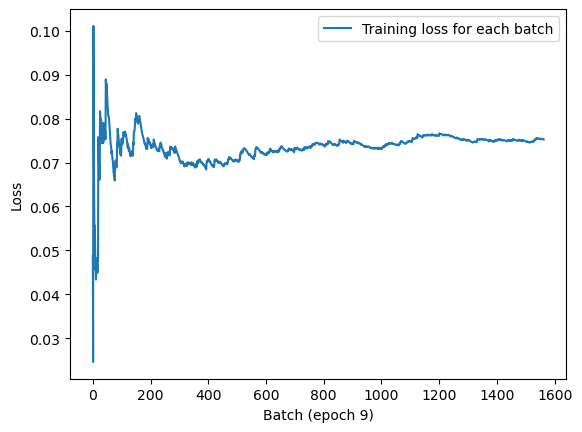

In [6]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []
        
    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))
        
    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses, 
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []
        

model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))

## 7.3.4 Monitoring and visualization with TensorBoard

To do good research or develop good models, you need rich, frequent feedback about
what’s going on inside your models during your experiments. That’s the point of running experiments: to get information about how well a model performs—as much
information as possible. Making progress is an iterative process, a loop—you start with
an idea and express it as an experiment, attempting to validate or invalidate your idea.
You run this experiment and process the information it generates. This inspires your
next idea. The more iterations of this loop you’re able to run, the more refined and
powerful your ideas become. Keras helps you go from idea to experiment in the least
possible time, and fast GPUs can help you get from experiment to result as quickly as
possible. But what about processing the experiment’s results? That’s where TensorBoard comes in.

TensorBoard (www.tensorflow.org/tensorboard) is a browser-based application that
you can run locally. It’s the best way to monitor everything that goes on inside your
model during training. With TensorBoard, you can
- Visually monitor metrics during training
- Visualize your model architecture
- Visualize histograms of activations and gradients
- Explore embeddings in 3D

If you’re monitoring more information than just the model’s final loss, you can
develop a clearer vision of what the model does and doesn’t do, and you can make
progress more quickly.

 The easiest way to use TensorBoard with a Keras model and the `fit()` method is to
use the `keras.callbacks.TensorBoard` callback.

 In the simplest case, just specify where you want the callback to write logs, and
you’re good to go:

In [7]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

tensorboard = keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_log_dir",
)

model.fit(train_images, train_labels,
          epochs=10,
          validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

Epoch 1/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.2916 - accuracy: 0.9140 - val_loss: 0.1416 - val_accuracy: 0.9596
Epoch 2/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1593 - accuracy: 0.9551 - val_loss: 0.1164 - val_accuracy: 0.9676
Epoch 3/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1296 - accuracy: 0.9632 - val_loss: 0.1077 - val_accuracy: 0.9710
Epoch 4/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1157 - accuracy: 0.9671 - val_loss: 0.1060 - val_accuracy: 0.9729
Epoch 5/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1058 - accuracy: 0.9708 - val_loss: 0.0916 - val_accuracy: 0.9778
Epoch 6/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.0951 - accuracy: 0.9757 - val_loss: 0.0922 - val_accuracy: 0.9776
Epoch 7/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.0912 - accuracy: 0.9757 - val_loss: 0.0920 - val_ac

Once the model starts running, it will write logs at the target location. If you are running your Python script on a local machine, you can then launch the local TensorBoard server using the following command (note that the `tensorboard` executable
should be already available if you have installed TensorFlow via `pip`; if not, you can
install TensorBoard manually via `pip install tensorboard`):

`tensorboard --logdir /full_path_to_your_log_dir`

You can then navigate to the URL that the command returns in order to access the
TensorBoard interface.

 If you are running your script in a Colab notebook, you can run an embedded TensorBoard instance as part of your notebook, using the following commands:
 
`%load_ext tensorboard`

`%tensorboard --logdir /full_path_to_your_log_dir`

In the TensorBoard interface, you will be able to monitor live graphs of your training
and evaluation metrics.

# 7.4 Writing your own training and evaluation loops

The `fit()` workflow strikes a nice balance between ease of use and flexibility. It’s what
you will use most of the time. However, it isn’t meant to support everything a deep
learning researcher may want to do, even with custom metrics, custom losses, and custom callbacks.

 After all, the built-in `fit()` workflow is solely focused on supervised learning: a setup
where there are known *targets* (also called *labels* or *annotations*) associated with your
input data, and where you compute your loss as a function of these targets and the
model’s predictions. However, not every form of machine learning falls into this
category. There are other setups where no explicit targets are present, such as *generative learning* (which we will discuss in chapter 12), *self-supervised learning* (where targets
are obtained from the inputs), and *reinforcement learning* (where learning is driven by
occasional “rewards,” much like training a dog). Even if you’re doing regular supervised learning, as a researcher, you may want to add some novel bells and whistles that
require low-level flexibility.

Whenever you find yourself in a situation where the built-in `fit()` is not enough,
you will need to write your own custom training logic. You already saw simple examples of low-level training loops in chapters 2 and 3. As a reminder, the contents of a
typical training loop look like this:
1. Run the forward pass (compute the model’s output) inside a gradient tape to
obtain a loss value for the current batch of data.
2. Retrieve the gradients of the loss with regard to the model’s weights.
3. Update the model’s weights so as to lower the loss value on the current batch
of data.

These steps are repeated for as many batches as necessary. This is essentially what
`fit()` does under the hood. In this section, you will learn to reimplement `fit()` from
scratch, which will give you all the knowledge you need to write any training algorithm
you may come up with.
 Let’s go over the details.

## 7.4.1 Training vs. inference

In the low-level training loop examples you’ve seen so far, step 1 (the forward pass)
was done via `predictions = model(inputs)`, and step 2 (retrieving the gradients
computed by the gradient tape) was done via `gradients = tape.gradient(loss,
model.weights)`. In the general case, there are actually two subtleties you need to take
into account.

Some Keras layers, such as the `Dropout` layer, have different behaviors during training
and during inference (when you use them to generate predictions). Such layers expose
a `training` Boolean argument in their `call()` method. Calling `dropout(inputs,
training=True)` will drop some activation entries, while calling `dropout(inputs,
training=False)` does nothing. By extension, Functional and Sequential models also
expose this training argument in their `call()` methods. Remember to pass `training
=True` when you call a Keras model during the forward pass! Our forward pass thus
becomes `predictions = model(inputs, training=True)`.

 In addition, note that when you retrieve the gradients of the weights of your
model, you should not use `tape.gradients(loss, model.weights)`, but rather `tape
.gradients(loss, model.trainable_weights)`. Indeed, layers and models own two
kinds of weights:
- *Trainable weights*—These are meant to be updated via backpropagation to minimize the loss of the model, such as the kernel and bias of a `Dense` layer.
- *Non-trainable weights*—These are meant to be updated during the forward pass
by the layers that own them. For instance, if you wanted a custom layer to keep
a counter of how many batches it has processed so far, that information would
be stored in a non-trainable weight, and at each batch, your layer would increment the counter by one.

Among Keras built-in layers, the only layer that features non-trainable weights is the
`BatchNormalization` layer, which we will discuss in chapter 9. The `BatchNormalization`
layer needs non-trainable weights in order to track information about the mean and
standard deviation of the data that passes through it, so as to perform an online
approximation of *feature normalization* (a concept you learned about in chapter 6).

 Taking into account these two details, a supervised-learning training step ends up
looking like this:

```python
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradients(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(model.trainable_weights, gradients))
```

## 7.4.2 Low-level usage of metrics

In a low-level training loop, you will probably want to leverage Keras metrics (whether
custom ones or the built-in ones). You’ve already learned about the metrics API: simply call `update_state(y_true, y_pred)` for each batch of targets and predictions, and
then use `result()` to query the current metric value:

In [8]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
metric.update_state(targets, predictions)
current_result = metric.result()
print(f"result: {current_result:.2f}")

result: 1.00


You may also need to track the average of a scalar value, such as the model’s loss. You
can do this via the `keras.metrics.Mean` metric:

In [9]:
values = [0, 1, 2, 3, 4]
mean_tracker = keras.metrics.Mean()
for value in values:
    mean_tracker.update_state(value)
print(f"Mean of values: {mean_tracker.result():.2f}")

Mean of values: 2.00


Remember to use `metric.reset_state()` when you want to reset the current results
(at the start of a training epoch or at the start of evaluation). 

## 7.4.3 A complete training and evaluation loop

Let’s combine the forward pass, backward pass, and metrics tracking into a `fit()`-like
training step function that takes a batch of data and targets and returns the logs that
would get displayed by the `fit()` progress bar.

### *Writing a step-by-step training loop: the training step function*

In [10]:
model = get_mnist_model()

# Prepare the loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy()
# Prepare the optimizer
optimizer = keras.optimizers.RMSprop()
# Prepare a list of metrics to monitor.
metrics = [keras.metrics.SparseCategoricalAccuracy()]
# Prepare a Mean metric tracker to keep track of the loss average.
loss_tracking_metric = keras.metrics.Mean()

def train_step(inputs, targets):
    # Run the forward pass. Note that we pass training=True.
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
        
    # Run the backward pass. Note that we use the model.trainable_weights.
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    # Keep track of metrics.
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()
    
    # Keep track of the loss average.
    loss_tracking_metric.update_state(loss)
    logs["loss"] = loss_tracking_metric.result()
    
    # Return the current value of the metrics and the loss.
    return logs

We will need to reset the state of our metrics at the start of each epoch and before running evaluation. Here's a utility function to do it.

### *Writing a step-by-step training loop: resetting the metrics*

In [11]:
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_state()

We can now lay out our complete training loop. Note that we use a `tf.data.Dataset` object to turn our NumPy data into an iterator that iterates over the data in batches of size 32.

### *Writing a step-by-step training loop: the loop itself*

In [12]:
training_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3

for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch, targets_batch)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")

Results at the end of epoch 0
...sparse_categorical_accuracy: 0.9129
...loss: 0.2919
Results at the end of epoch 1
...sparse_categorical_accuracy: 0.9533
...loss: 0.1587
Results at the end of epoch 2
...sparse_categorical_accuracy: 0.9633
...loss: 0.1291


And here’s the evaluation loop: a simple `for` loop that repeatedly calls a `test_step()`
function, which processes a single batch of data. The `test_step()` function is just a subset of the logic of `train_step()`. It omits the code that deals with updating the weights
of the model—that is to say, everything involving the `GradientTape` and the optimizer.

### *Writing a step-by-step evaluation loop*

In [13]:
def test_step(inputs, targets):
    # Note that we pass training=False.
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
    
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()
        
    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics() 
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9689
...val_loss: 0.1189


Congrats—you’ve just reimplemented `fit()` and `evaluate()`! Or almost: `fit()`
and `evaluate()` support many more features, including large-scale distributed computation, which requires a bit more work. It also includes several key performance
optimizations.

 Let’s take a look at one of these optimizations: TensorFlow function compilation.

## 7.4.4 Make it fast with tf.function

You may have noticed that your custom loops are running significantly slower than the
built-in `fit()` and `evaluate()`, despite implementing essentially the same logic.
That’s because, by default, TensorFlow code is executed line by line, *eagerly*, much like
NumPy code or regular Python code. Eager execution makes it easier to debug your
code, but it is far from optimal from a performance standpoint.

 It’s more performant to *compile* your TensorFlow code into a computation graph that
can be globally optimized in a way that code interpreted line by line cannot. The syntax to do this is very simple: just add a `@tf.function` to any function you want to compile before executing.

### *Adding a `@tf.function` decorator to our evaluation-step function*

In [14]:
@tf.function    # This is the only line that changed.
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
    
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()
        
    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics() 
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9689
...val_loss: 0.1189


On the Colab CPU, we go from taking 1.80 s to run the evaluation loop to only 0.8 s.
Much faster!

 Remember, while you are debugging your code, prefer running it eagerly, without
any `@tf.function` decorator. It’s easier to track bugs this way. Once your code is working and you want to make it fast, add a `@tf.function` decorator to your training step
and your evaluation step—or any other performance-critical function.

## 7.4.5 Leveraging `fit()` with a custom training loop

In the previous sections, we were writing our own training loop entirely from scratch.
Doing so provides you with the most flexibility, but you end up writing a lot of code
while simultaneously missing out on many convenient features of `fit()`, such as callbacks or built-in support for distributed training.

What if you need a custom training algorithm, but you still want to leverage the
power of the built-in Keras training logic? There’s actually a middle ground between
`fit()` and a training loop written from scratch: you can provide a custom training
step function and let the framework do the rest.

 You can do this by overriding the `train_step()` method of the Model class. This is
the function that is called by `fit(`) for every batch of data. You will then be able to call
`fit()` as usual, and it will be running your own learning algorithm under the hood.

 Here’s a simple example:
- We create a new class that subclasses `keras.Model`.
- We override the method `train_step(self, data)`. Its contents are nearly identical to what we used in the previous section. It returns a dictionary mapping
metric names (including the loss) to their current values.
- We implement a `metrics` property that tracks the model’s `Metric` instances.
This enables the model to automatically call `reset_state()` on the model’s
metrics at the start of each epoch and at the start of a call to `evaluate()`, so you
don’t have to do it by hand.

### *Implementing a custom training step to use with `fit()`*

In [15]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
# This metric object will be used to track the average of per-batch losses during training and evaluation.
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    # Overide the train_step method.
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            # We use self(inputs, training=True) instead of model(inputs, training=True), since our model is the class itself.
            predictions = self(inputs, training=True)
            loss = loss_fn(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        
        # Update the loss tracker metric that tracks the average of the loss.
        loss_tracker.update_state(loss)
        # Return the average loss so far by querying the loss tracker metric.
        return {"loss": loss_tracker.result()}
    
    @property
    def metrics(self):
        return [loss_tracker]

We can now instantiate our custom model, compile it (we only pass the optimizer, since
the loss is already defined outside of the model), and train it using `fit()` as usual:

In [16]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop())
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 13s 8ms/step - loss: 0.2959
Epoch 2/3
1563/1563 [==============================] - 12s 8ms/step - loss: 0.1587
Epoch 3/3
1563/1563 [==============================] - 13s 8ms/step - loss: 0.1291


There are a couple of points to note:
- This pattern does not prevent you from building models with the Functional
API. You can do this whether you’re building Sequential models, Functional
API models, or subclassed models.
- You don’t need to use a `@tf.function` decorator when you override `train_step`—the framework does it for you.

Now, what about metrics, and what about configuring the loss via `compile()`? After
you’ve called `compile()`, you get access to the following:
- `self.compiled_loss`—The loss function you passed to `compile()`.
- `self.compiled_metrics`—A wrapper for the list of metrics you passed, which
allows you to call `self.compiled_metrics.update_state()` to update all of
your metrics at once.
- `self.metrics`—The actual list of metrics you passed to `compile()`. Note that it
also includes a metric that tracks the loss, similar to what we did manually with
our `loss_tracking_metric` earlier.

We can thus write

In [17]:
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            # Compute the loss via self.compiled_loss.
            loss = self.compiled_loss(targets, predictions)
            
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        
        # Update the model’s metrics via self.compiled_metrics.
        self.compiled_metrics.update_state(targets, predictions)
        
        # Return a dict mapping metric names to their current value.
        return {m.name: m.result() for m in self.metrics} 

In [18]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 15s 9ms/step - loss: 0.2961 - sparse_categorical_accuracy: 0.9121
Epoch 2/3
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1598 - sparse_categorical_accuracy: 0.9532
Epoch 3/3
1563/1563 [==============================] - 14s 9ms/step - loss: 0.1297 - sparse_categorical_accuracy: 0.9630


That was a lot of information, but you now know enough to use Keras to do almost
anything. 

## *Summary*

- Keras offers a spectrum of different workflows, based on the principle of *progressive disclosure of complexity*. They all smoothly inter-operate together.
- You can build models via the `Sequential` class, via the Functional API, or by subclassing the `Model` class. Most of the time, you’ll be using the Functional API.
- The simplest way to train and evaluate a model is via the default `fit()` and
`evaluate()` methods.
- Keras callbacks provide a simple way to monitor models during your call to
`fit()` and automatically take action based on the state of the model.
- You can also fully take control of what `fit()` does by overriding the `train_step()` method.
- Beyond `fit()`, you can also write your own training loops entirely from scratch.
This is useful for researchers implementing brand-new training algorithms.